In [ ]:
#necessary on linux/mac
#import multiprocessing

#if __name__ == '__main__':
#    multiprocessing.set_start_method('forkserver')

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.ensemble import BalancedRandomForestClassifier
import datetime
import matplotlib

import matplotlib.pyplot as plt

import DataPrep
import error_evaluation


c:\users\scott\anaconda3\envs\python35gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "c:\users\scott\anaconda3\envs\python35gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "c:\users\scott\anaconda3\envs\python35gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "c:\users\scott\anaconda3\envs\python35gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "c:\users\scott\anaconda3\envs\python35gpu\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "c:\users\scott\anaconda3\envs\python35gpu\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
from azureml.core import Workspace
from azureml.core import Experiment
ws = Workspace.get('scottchamlworkspace', subscription_id='7d2d1e21-7718-415a-b98e-780ef0b02ad5', resource_group='mlworkspacerg')
ws.write_config()

Falling back to use azure cli credentials. This fall back to use azure cli credentials will be removed in the next release. 
Make sure your code doesn't require 'az login' to have happened before using azureml-sdk, except the case when you are specifying AzureCliAuthentication in azureml-sdk.


Wrote the config file config.json to: D:\src\GitHub\OpenAvalancheProject\ML\aml_config\config.json


Wrote the config file config.json to: D:\src\GitHub\OpenAvalancheProject\ML\aml_config\config.json


In [122]:
exp = Experiment(workspace=ws, name='lightgbm-exp1')

In [ ]:
dp = DataPrep.DataPrep()
X_Above_test, X_Above_train, y_Above_test, y_Above_train, X_Near_test, X_Near_train, y_Near_test, y_Near_train, X_Below_test, X_Below_train, y_Below_test, y_Below_train = dp.prep_day1_danger_train_test(input_file='E:/Data/OAPMLData/V1.1CIAC_UAC_NWAC_FeaturesWithLabels30Days20131201To20180430.csv', ignore_extreme=True, only_critical_points=False, oversample=True, only_precise_points = False, label_critical_points=True)


In [124]:
run = exp.start_logging()
run.log(name="Model Type", value="EasyEnsembleClassifier")
run.log(name="Imbalance Correction", value="Remove Low Regions")
run.log(name="Amount of Lookback", value="30 days")
run.log(name="Feature Pruning", value="None")


In [ ]:
X_Above_test.to_pickle('E:/Temp/X_test.pkl')
X_Above_train.to_pickle('E:/Temp/X_train.pkl')

y_Above_test.to_pickle('E:/Temp/y_test.pkl')
y_Above_train.to_pickle('E:/Temp/y_train.pkl')

In [3]:
X_Above_test = pd.read_pickle('E:/Temp/X_test.pkl')
X_Above_train = pd.read_pickle('E:/Temp/X_train.pkl')

y_Above_test = pd.read_pickle('E:/Temp/y_test.pkl')
y_Above_train = pd.read_pickle('E:/Temp/y_train.pkl')

In [6]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

1    115837
2     66295
0     64432
3     13361
Name: o_Day1DangerAboveTreeline, dtype: int64

In [126]:
X_Above_test = X_Above_test.reset_index(drop=True)
X_Above_train = X_Above_train.reset_index(drop=True)
y_Above_test = y_Above_test.reset_index(drop=True)
y_Above_train = y_Above_train.reset_index(drop=True)
synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
X_Above_test = X_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]
X_Above_train = X_Above_train[~y_Above_train['UnifiedRegion'].isin(synthetic_regions)]
y_Above_test = y_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]
y_Above_train = y_Above_train[~y_Above_train['UnifiedRegion'].isin(synthetic_regions)]


In [127]:
len(X_Above_train)

226329

In [112]:
len(y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())

226329

In [130]:
from imblearn.ensemble import EasyEnsembleClassifier
#m = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=1400, max_features='sqrt', min_samples_leaf=1)
m = EasyEnsembleClassifier(n_jobs=-1, n_estimators=700)
m.fit(X_Above_train.values, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())
m.score(X_Above_train.values, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())
#m.fit(X_Above_train, y_Above_train)
#m.score(X_Above_train, y_Above_train)

0.49269868200716654

In [131]:
preds = m.predict(X_Above_test)

In [132]:
pd.Series(preds).value_counts()

1    20555
2    20475
3    11148
0    10685
dtype: int64

In [133]:
m.score(X_Above_test.values, y_Above_test['o_Day1DangerAboveTreeline'].values.ravel())


0.4921495951513609

In [134]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_Above_test['o_Day1DangerAboveTreeline'].values.ravel(), preds)

0.5592873824053276

In [135]:
X_Above_test.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev3DayFreezeThawLikeliness29InPast,c_r_Prev7DayFreezeThawLikeliness29InPast,c_r_Prev3DayWindSlabLikeliness29InPast,c_r_Prev7DayWindSlabLikeliness29InPast,c_r_Prev3DayFreezeThawLikeliness30InPast,c_r_Prev7DayFreezeThawLikeliness30InPast,c_r_Prev3DayWindSlabLikeliness30InPast,c_r_Prev7DayWindSlabLikeliness30InPast,c_IsCoastalSnowpack,c_IsContenentalSnowpack
0,0.00,2.830390,0.01,4.166778,0.05,3.875112,0.1,3.175281,0.1,2.613486,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,3.75,0.886337,7.20,1.988536,10.30,3.408619,12.0,4.518070,12.3,5.379788,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.00,1.908402,0.00,1.967396,0.00,2.083212,0.0,2.519561,0.0,2.239626,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
3,0.00,3.232829,0.00,3.107298,0.00,3.395886,0.0,4.155732,0.0,4.745046,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,1.05,3.241758,4.12,2.425065,8.69,2.687768,14.0,3.363188,16.1,4.923554,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [136]:
preds = m.predict(X_Above_test)
#only look at critical points
y_Above_test_crit = y_Above_test[y_Above_test['IsCriticalPoint']==True]
X_Above_test_crit = X_Above_test.loc[y_Above_test_crit.index, :]
preds_crit = m.predict(X_Above_test_crit)
#split in to forecast types
X_Above_test_cont = X_Above_test[X_Above_test['c_IsContenentalSnowpack']==True]
y_Above_test_cont = y_Above_test.loc[X_Above_test_cont.index, :]
preds_cont = m.predict(X_Above_test_cont)
y_Above_test_cont['Prediction'] = preds_cont

X_Above_test_coast = X_Above_test[X_Above_test['c_IsCoastalSnowpack']==True]
y_Above_test_coast = y_Above_test.loc[X_Above_test_coast.index, :]
preds_coast = m.predict(X_Above_test_coast)
y_Above_test_coast['Prediction'] = preds_coast

y_Above_test['Prediction'] = preds
#remove synthetic regions from the evaluation
synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
y_Above_test = y_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]
y_Above_test_cont = y_Above_test_cont[~y_Above_test_cont['UnifiedRegion'].isin(synthetic_regions)]
y_Above_test_coast = y_Above_test_coast[~y_Above_test_coast['UnifiedRegion'].isin(synthetic_regions)]

preds = y_Above_test['Prediction']
preds_cont = y_Above_test_cont['Prediction']
preds_coast = y_Above_test_coast['Prediction']

Accuracy: 0.4921495951513609
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.71      0.45      4979
           1       0.74      0.46      0.57     32996
           2       0.43      0.46      0.44     19113
           3       0.32      0.62      0.42      5775

   micro avg       0.49      0.49      0.49     62863
   macro avg       0.45      0.56      0.47     62863
weighted avg       0.57      0.49      0.51     62863

Normalized confusion matrix
Confusion matrix, without normalization
Accuracy: 0.4850147741663149
Classification Report
              precision    recall  f1-score   support

           0       0.38      0.68      0.49       184
           1       0.76      0.42      0.54      1226
           2       0.41      0.48      0.44       735
           3       0.32      0.72      0.44       224

   micro avg       0.49      0.49      0.49      2369
   macro avg       0.47      0.57      0.48      2369
weighted avg   

<Figure size 432x288 with 0 Axes>

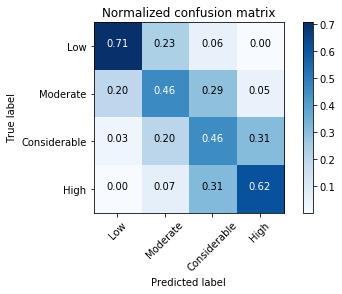

<Figure size 432x288 with 0 Axes>

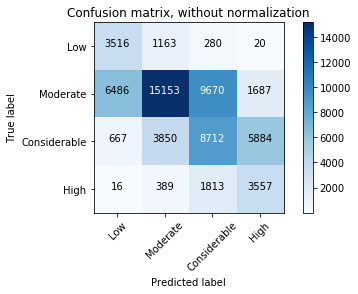

<Figure size 432x288 with 0 Axes>

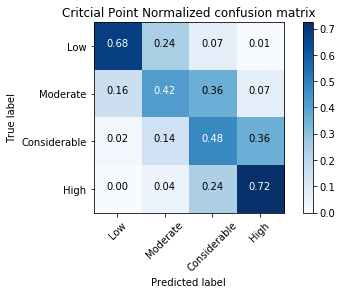

<Figure size 432x288 with 0 Axes>

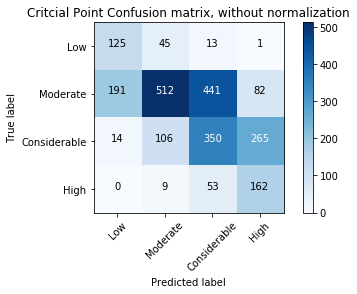

<Figure size 432x288 with 0 Axes>

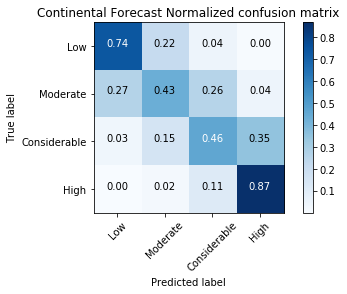

<Figure size 432x288 with 0 Axes>

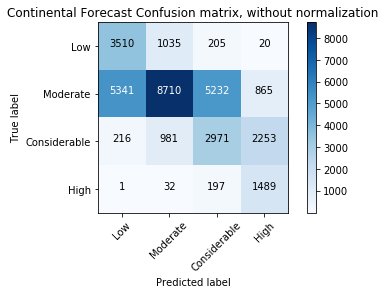

<Figure size 432x288 with 0 Axes>

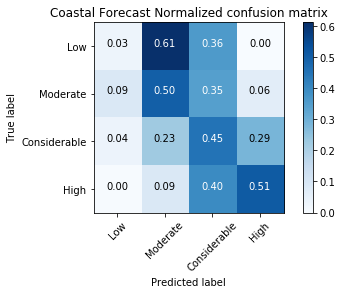

<Figure size 432x288 with 0 Axes>

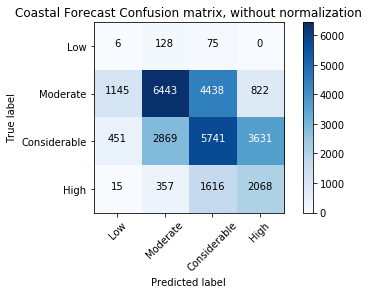

In [137]:

report_all = error_evaluation.evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], preds)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], preds)
plt.figure()
figure_all_norm = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                                                         title='Normalized confusion matrix')

plt.figure()
figure_all = error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Confusion matrix, without normalization')
plt.figure()
report_crit = error_evaluation.evaluateSingleClassShort(y_Above_test_crit['o_Day1DangerAboveTreeline'], preds_crit)
cnf_matrix_crit = confusion_matrix(y_Above_test_crit['o_Day1DangerAboveTreeline'], preds_crit)

figure_crit_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Critcial Point Normalized confusion matrix')
plt.figure()
figure_crit = error_evaluation.plot_confusion_matrix(cnf_matrix_crit, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Critcial Point Confusion matrix, without normalization')

plt.figure()
report_cont = error_evaluation.evaluateSingleClassShort(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)
cnf_matrix_cont = confusion_matrix(y_Above_test_cont['o_Day1DangerAboveTreeline'], preds_cont)

figure_cont_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Continental Forecast Normalized confusion matrix')
plt.figure()
figure_cont = error_evaluation.plot_confusion_matrix(cnf_matrix_cont, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Continental Forecast Confusion matrix, without normalization')

plt.figure()
report_coast = error_evaluation.evaluateSingleClassShort(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)
cnf_matrix_coast = confusion_matrix(y_Above_test_coast['o_Day1DangerAboveTreeline'], preds_coast)

figure_coast_norm = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                          title='Coastal Forecast Normalized confusion matrix')
plt.figure()
figure_coast = error_evaluation.plot_confusion_matrix(cnf_matrix_coast, classes=['Low', 'Moderate', 'Considerable', 'High'],
                          title='Coastal Forecast Confusion matrix, without normalization')
plt.show()

In [138]:
run.log(name='Micro Avg F1', value=report_all['micro avg']['f1-score'])

run.log_image(name='All Regions', plot=figure_all_norm)
run.log_image(name='Critical Points', plot=figure_crit_norm)
run.log_image(name='Contenental Points', plot=figure_cont_norm)
run.log_image(name='Coastal Points', plot=figure_coast_norm)

run.log(name='All Low f1', value=report_all['0']['f1-score'])
run.log(name='All Moderate f1', value=report_all['1']['f1-score'])
run.log(name='All Considerable f1', value=report_all['2']['f1-score'])
run.log(name='All High f1', value=report_all['3']['f1-score'])
run.log(name='All Micro Avg F1', value=report_all['micro avg']['f1-score'])

run.log(name='Crit Low f1', value=report_crit['0']['f1-score'])
run.log(name='Crit Moderate f1', value=report_crit['1']['f1-score'])
run.log(name='Crit Considerable f1', value=report_crit['2']['f1-score'])
run.log(name='Crit High f1', value=report_crit['3']['f1-score'])
run.log(name='Crit Micro Avg F1', value=report_crit['micro avg']['f1-score'])

run.log(name='Cont Low f1', value=report_cont['0']['f1-score'])
run.log(name='Cont Moderate f1', value=report_cont['1']['f1-score'])
run.log(name='Cont Considerable f1', value=report_cont['2']['f1-score'])
run.log(name='Cont High f1', value=report_cont['3']['f1-score'])
run.log(name='Cont Micro Avg F1', value=report_cont['micro avg']['f1-score'])

run.log(name='Coast Low f1', value=report_coast['0']['f1-score'])
run.log(name='Coast Moderate f1', value=report_coast['1']['f1-score'])
run.log(name='Coast Considerable f1', value=report_coast['2']['f1-score'])
run.log(name='Coast High f1', value=report_coast['3']['f1-score'])
run.log(name='Coast Micro Avg F1', value=report_coast['micro avg']['f1-score'])

run.log(name='Parameters', value=m.get_params())
run.complete()


Converted key Parameters of value {'sampling_strategy': 'auto', 'n_jobs': -1, 'base_estimator': None, 'replacement': False, 'random_state': None, 'warm_start': False, 'n_estimators': 700, 'verbose': 0} to {'sampling_strategy': 'auto', 'n_jobs': -1, 'base_estimator': None, 'replacement': False, 'random_state': None, 'warm_start': False, 'n_estimators': 700, 'verbose': 0}.



In [105]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
param_grid = { 
    'n_estimators': [500, 700],
    'max_features': [None, 'sqrt'],
    'min_samples_leaf': [1, 3]
}
m = BalancedRandomForestClassifier(n_jobs=2)
CV_rfc = GridSearchCV(estimator=m, param_grid=param_grid, scoring="f1_micro", cv=tscv, n_jobs=6, verbose=10)
CV_rfc.fit(X_Above_train.values, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())
print(CV_rfc.best_params_)
means = CV_rfc.cv_results_['mean_test_score']
stds = CV_rfc.cv_results_['std_test_score']
params = CV_rfc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 59.4min
[Parallel(n_jobs=6)]: Done   7 out of  16 | elapsed: 118.8min remaining: 152.7min
[Parallel(n_jobs=6)]: Done   9 out of  16 | elapsed: 129.1min remaining: 100.4min
[Parallel(n_jobs=6)]: Done  11 out of  16 | elapsed: 143.3min remaining: 65.1min
[Parallel(n_jobs=6)]: Done  13 out of  16 | elapsed: 162.5min remaining: 37.5min
[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed: 6454.8min finished


{'min_samples_leaf': 1, 'n_estimators': 700, 'max_features': 'sqrt'}
0.608274 (0.011996) with: {'min_samples_leaf': 1, 'n_estimators': 500, 'max_features': None}
0.608506 (0.013023) with: {'min_samples_leaf': 1, 'n_estimators': 700, 'max_features': None}
0.600579 (0.014256) with: {'min_samples_leaf': 3, 'n_estimators': 500, 'max_features': None}
0.599645 (0.012486) with: {'min_samples_leaf': 3, 'n_estimators': 700, 'max_features': None}
0.613198 (0.015449) with: {'min_samples_leaf': 1, 'n_estimators': 500, 'max_features': 'sqrt'}
0.614921 (0.014813) with: {'min_samples_leaf': 1, 'n_estimators': 700, 'max_features': 'sqrt'}
0.604403 (0.019286) with: {'min_samples_leaf': 3, 'n_estimators': 500, 'max_features': 'sqrt'}
0.604894 (0.016648) with: {'min_samples_leaf': 3, 'n_estimators': 700, 'max_features': 'sqrt'}


In [ ]:
y_Above_test.to_csv("evaluate_prediction2.csv")

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__)
init_notebook_mode(connected=True)

In [ ]:
to_plot = y_Above_test[y_Above_test['o_Day1DangerAboveTreeline']=='High']

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = to_plot['Lat'].values,
        lon = to_plot['Lon'].values,
        text = 'High',
        mode = 'markers',
        marker = dict(
            size = 1,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = True,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            )
       
        ))]
layout = dict(
        title = 'Test Prediction Points',
        
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
iplot( fig )

In [ ]:
to_plot.to_csv("outsample.csv")

In [23]:
importances = pd.Series(m.feature_importances_)
out = pd.concat([pd.Series(X_Above_train.columns), importances], axis=1)
out.columns=['Feature','Score']

In [26]:
out.sort_values(by=['Score'], ascending=False)[50:]

,Feature,Score
47,n_f_10mWindSpeedMax,0.002704
117,n_r_SNOWDAS_SolidPrecip_kgpersquarem2InPast,0.002619
157,n_r_SNOWDAS_SnowDepth_mm4InPast,0.002598
0,n_f_APCPsurface1HourForecast,0.002594
180,n_r_SNOWDAS_SWE_mm5InPast,0.002575
64,n_r_Prev1dayMinTemp,0.002543
80,n_r_Prev3dayMaxTemp1InPast,0.002453
57,n_r_Prev3DayMax10mWind,0.002452
158,n_r_SNOWDAS_SWE_mm4InPast,0.002378
202,n_r_SNOWDAS_SWE_mm6InPast,0.002360


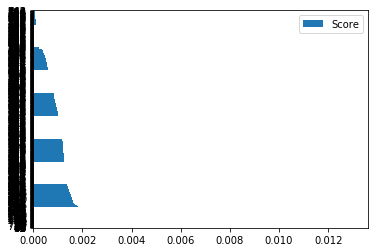

In [25]:
out.sort_values(by=['Score'], ascending=False).plot.barh()
plt.show()

In [27]:
important_features= out[out['Score'] > .001].sort_values(by=['Score'], ascending=False)['Feature']

52                                  n_f_APCPsurface
73             n_r_SNOWDAS_SolidPrecip_kgpersquarem
65                               n_r_Prev1DayPrecip
42                    n_f_APCPsurface22HourForecast
44                    n_f_APCPsurface23HourForecast
38                    n_f_APCPsurface20HourForecast
30                    n_f_APCPsurface16HourForecast
20                    n_f_APCPsurface11HourForecast
32                    n_f_APCPsurface17HourForecast
36                    n_f_APCPsurface19HourForecast
737                                     DayOfSeason
18                    n_f_APCPsurface10HourForecast
95      n_r_SNOWDAS_SolidPrecip_kgpersquarem1InPast
54                     n_r_Prev3daySnowAccumulation
55                     n_r_Prev7daySnowAccumulation
26                    n_f_APCPsurface14HourForecast
28                    n_f_APCPsurface15HourForecast
22                    n_f_APCPsurface12HourForecast
89                        n_r_Prev1DayPrecip1InPast
34          

In [54]:
X_Above_test_imp = X_Above_test[important_features.append(pd.Series(['c_IsContenentalSnowpack', 'c_IsCoastalSnowpack']))]
X_Above_train_imp = X_Above_train[important_features.append(pd.Series(['c_IsContenentalSnowpack', 'c_IsCoastalSnowpack']))]

In [33]:
X_Above_test = X_Above_test_imp
X_Above_train = X_Above_train_imp

In [36]:
m2 = RandomForestClassifier(n_jobs = -1,
                           oob_score=True,
                           n_estimators=700,
                           #max_features="sqrt",
                           #min_samples_leaf=3,   
                           )
m2.fit(X_Above_train_imp, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())
m2.score(X_Above_train_imp, y_Above_train['o_Day1DangerAboveTreeline'].values.ravel())

1.0

In [37]:
preds2 = m2.predict(X_Above_test_imp)

In [42]:
y_Above_test['preds'] = preds2

In [43]:
#remove synthetic regions from the evaluation

synthetic_regions = ['Low West', 'Low East', 'In The Desert', 'In The Lake']
y_Above_test = y_Above_test[~y_Above_test['UnifiedRegion'].isin(synthetic_regions)]

In [44]:
preds2 = y_Above_test['preds']

Accuracy: 0.6185673607686556
Classification Report
              precision    recall  f1-score   support

           0       0.43      0.10      0.16      4979
           1       0.68      0.79      0.73     32996
           2       0.52      0.61      0.56     19113
           3       0.71      0.13      0.23      5775

   micro avg       0.62      0.62      0.62     62863
   macro avg       0.58      0.41      0.42     62863
weighted avg       0.61      0.62      0.59     62863

Normalized confusion matrix
Confusion matrix, without normalization


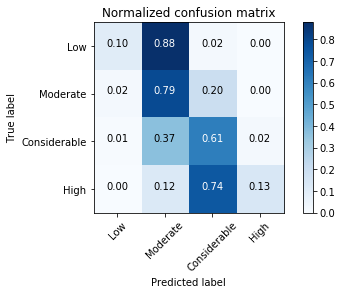

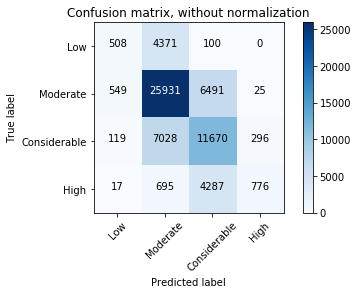

In [46]:
error_evaluation.evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], preds2)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], preds2)
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'], normalize=True,
                      title='Normalized confusion matrix')

plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Low', 'Moderate', 'Considerable', 'High'],
                      title='Confusion matrix, without normalization')

In [ ]:
importances2 = pd.Series(m2.feature_importances_)
out = pd.concat([pd.Series(X_Above_train_imp.columns), importances2], axis=1)
out.columns=['Feature','Score']

In [ ]:
out.sort_values(by=['Score'], ascending=False)[:10]

In [ ]:
out.sort_values(by=['Score'], ascending=False).plot.barh()
plt.show()

In [ ]:
import re
for x in range(1, 15):
    subset_cols = ['DayOfYear',
    'c_IsContenentalSnowpack',
    'c_IsCoastalSnowpack',
    'n_f_APCPsurface1HourForecast',
    'n_f_10mWindSpeed1HourForecast',
    'n_f_APCPsurface2HourForecast',
    'n_f_10mWindSpeed2HourForecast',
    'n_f_APCPsurface3HourForecast',
    'n_f_10mWindSpeed3HourForecast',
    'n_f_APCPsurface4HourForecast',
    'n_f_10mWindSpeed4HourForecast',
    'n_f_APCPsurface5HourForecast',
    'n_f_10mWindSpeed5HourForecast',
    'n_f_APCPsurface6HourForecast',
    'n_f_10mWindSpeed6HourForecast',
    'n_f_APCPsurface7HourForecast',
    'n_f_10mWindSpeed7HourForecast',
    'n_f_APCPsurface8HourForecast',
    'n_f_10mWindSpeed8HourForecast',
    'n_f_APCPsurface9HourForecast',
    'n_f_10mWindSpeed9HourForecast',
    'n_f_APCPsurface10HourForecast',
    'n_f_10mWindSpeed10HourForecast',
    'n_f_APCPsurface11HourForecast',
    'n_f_10mWindSpeed11HourForecast',
    'n_f_APCPsurface12HourForecast',
    'n_f_10mWindSpeed12HourForecast',
    'n_f_APCPsurface13HourForecast',
    'n_f_10mWindSpeed13HourForecast',
    'n_f_APCPsurface14HourForecast',
    'n_f_10mWindSpeed14HourForecast',
    'n_f_APCPsurface15HourForecast',
    'n_f_10mWindSpeed15HourForecast',
    'n_f_APCPsurface16HourForecast',
    'n_f_10mWindSpeed16HourForecast',
    'n_f_APCPsurface17HourForecast',
    'n_f_10mWindSpeed17HourForecast',
    'n_f_APCPsurface18HourForecast',
    'n_f_10mWindSpeed18HourForecast',
    'n_f_APCPsurface19HourForecast',
    'n_f_10mWindSpeed19HourForecast',
    'n_f_APCPsurface20HourForecast',
    'n_f_10mWindSpeed20HourForecast',
    'n_f_APCPsurface21HourForecast',
    'n_f_10mWindSpeed21HourForecast',
    'n_f_APCPsurface22HourForecast',
    'n_f_10mWindSpeed22HourForecast',
    'n_f_APCPsurface23HourForecast',
    'n_f_10mWindSpeed23HourForecast',
    'n_f_tempMaxF',
    'n_f_10mWindSpeedMax',
    'n_r_snowDepthIn',
    'n_f_tempMinF',
    'n_f_tempAveF',
    'n_f_10mWindSpeed',
    'n_f_APCPsurface',
    'n_r_precipIncrementSnowIn',
    'n_r_Prev3daySnowAccumulation',
    'n_r_Prev7daySnowAccumulation',
    'n_r_Prev3dayMaxTemp',
    'n_r_Prev3DayMax10mWind',
    'n_r_Prev3dayMinTemp',
    'n_r_Prev7dayMaxTemp',
    'n_r_Prev7DayMax10mWind',
    'n_r_Prev7dayMinTemp',
    'n_r_Prev1dayMaxTemp',
    'n_r_Prev1DayMax10mWind',
    'n_r_Prev1dayMinTemp',
    'n_r_Prev1DayPrecip',
    'n_f_Next24HourChangeInTempFromPrev3DayMax',
    'n_f_Next24HoursChangeInTempFromPrev1DayMax',
    'n_r_Prev24HoursPrecipAsRainTotalIn',
    'n_r_SNOWDAS_SnowDepth_mm',
    'n_r_SNOWDAS_SWE_mm',
    'n_r_SNOWDAS_SnowmeltRunoff_micromm',
    'n_r_SNOWDAS_Sublimation_micromm',
    'n_r_SNOWDAS_SolidPrecip_kgpersquarem',
    'n_r_SNOWDAS_LiquidPrecip_kgpersquarem',
    'n_r_SNOWDAS_SnowpackAveTemp_k']
    for y in range(1, x):
        day_regex = ""
        #print("loop x: " + str(x) + " y: " + str(y))
        expression = '.+\D'+str(y)+'InPast'
        #print("e:"+expression)
        day_regex = re.compile(expression)
        match_cols = list(filter(day_regex.match, cols))
        #print("match len: " + str(len(match_cols)))
        subset_cols = subset_cols + match_cols
    print("Have len: " + str(len(subset_cols)))
    ds = X_Near_train[subset_cols]
    ds_test = X_Near_test[subset_cols]
    m3 = RandomForestClassifier(n_jobs = -1,
                           oob_score=True,
                           n_estimators=500,
                           max_features="sqrt"
                           )
    m3.fit(ds.values, y_Near_train['o_Day1DangerNearTreeline'].values.ravel())
    preds3 = m3.predict(ds_test)
    error_evaluation.evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], preds3)
    
    

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
#X, y = make_classification(n_samples=500, n_features=25,
#                           n_clusters_per_class=1, n_informative=15,
#                           random_state=RANDOM_STATE)
X = X_Above_train
y = y_Above_train[yColumns]

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               n_jobs = 3,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               n_jobs = 3,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               n_jobs=3,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 500

for label, clf in ensemble_clfs:
    i = min_estimators
    for i in range(min_estimators, max_estimators + 1, 25):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:

lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')
def find_nearest_forecast_point(row):
    
    tmp_lat_lon_cache = lat_lon_cache.copy()
   
    #TODO: currently a simple esitmate for converting lon to miles, 53 degrees per mile--need to do better for the real deal
    tmp_lat_lon_cache['distance'] = np.sqrt(np.square(69.0*(lat_lon_cache['Lat']-row['Lat'])) + np.square(53.0*(lat_lon_cache['Lon']-row['Lon'])))
    #tmp_lat_lon_cache['distance'] = tmp_lat_lon_cache[:3].apply(lambda x: estimate_distance_between_points_mi(lat, lon, x['Lat'], x['Lon']), axis=1)
    print("after distance calc")
    #nearest point needs to be within 20 miles
    nearest_row = tmp_lat_lon_cache.sort_values(by=['distance']).iloc[0, :]
    if nearest_row['distance'] > 20.0:
        #should never happen since our grid is smaller but just in case
        return -1, -1
    else:
        return nearest_row['Lat'], nearest_row['Lon']

In [ ]:
def is_critical_point(row, critical_points):
    for cp in critical_points:
        if(row['Lat'] == cp[0] and row['Lon'] == cp[1]):
            return True
    return False

lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')
critical_points = pd.read_csv('../Data/CriticalPointsToForecast.csv')
critical_forecast_points = critical_points.apply(find_nearest_forecast_point, axis=1)




        

In [ ]:

#X_Above_test, X_Above_train, y_Above_test, y_Above_train
tmp = y_Above_test.apply(lambda x: is_critical_point(x, critical_forecast_points), axis=1)


In [ ]:
tmp.value_counts()

In [ ]:
lat_lon_cache = pd.read_csv('../Data/LatLonCache.csv')

In [ ]:
critical_points = pd.read_csv('../Data/CriticalPointsToForecast.csv')

In [ ]:
lat_lon_cache.columns

In [ ]:
np.sqrt(np.square(69.0*(lat_lon_cache['Lat']-47.981010)) + np.square(53.0*(lat_lon_cache['Lon']--123.472400)))